# Deep Learning - Project 2 - Convolutional Neural Networks
Authors: Joanna Działo 148260, Wojciech Majewski 148253

## Part 1 - Implementation of an image classifier (40%)

The dataset we chose is, as per suggestion, Caltech-101.

In [1]:
PATH = "/content/data/101_ObjectCategories"

We put all the imports here, to avoid redundancy:

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras import datasets, layers, models
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import itertools
from collections import Counter
import random
from sklearn.metrics import classification_report

### 1) Download the data and load it in the Notebook (5%)

**! DISCLAIMER !** These functions work on Google Colab, we do not guarantee that they would work on a regular, windows/mac/linux based system. In this part we also remove two folders from the dataset, but we elaborate on that further in the summary in Part1.7)

In [3]:
!wget -O caltech-101.zip https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip
!unzip caltech-101.zip -d caltech
!mkdir data
!tar -xvf "/content/caltech/caltech-101/101_ObjectCategories.tar.gz" -C "/content/data"
!rm -rf caltech-101.zip
!rm -rf caltech
!rm -rf /content/data/101_ObjectCategories/Faces_easy
!rm -rf /content/data/101_ObjectCategories/BACKGROUND_Google

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
101_ObjectCategories/chair/image_0005.jpg
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectC

We implemented some useful functions for displaying images. The first one takes one image and the second takes 25, with or without labels depending on the users humour.

In [4]:
def imshow(image, label = None):
    plt.imshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if label == None:
        plt.show()
    else:
        plt.xlabel(label)
        plt.show()

def display_images(images, labels = None):
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cv2.cvtColor(images[i].astype('uint8'), cv2.COLOR_BGR2RGB), cmap=plt.cm.binary)
        if labels != None:
            plt.xlabel(labels[i])
    plt.show()

Here we set the image size which is used in resizing and setting the input layer of the NN.

In [5]:
img_size = 64

This function loads images of one category. The limit parameter, if used, limts the number of images that are being loaded

In [6]:
def load_images(path, category, limit = None):
    category_path = os.path.join(path, category)
    images_paths = [os.path.join(category_path,img) for img in os.listdir(category_path)]
    images = [cv2.resize(cv2.imread(f, 1), (img_size, img_size)) for f in images_paths]
    labels = [category for i in range(0, len(os.listdir(category_path)))]
    if limit == None:
        return images, labels
    else:
        limit_norm = min(limit, len(images))
        return images[:limit_norm], labels[:limit_norm]

This function creates the dataset from a given path - it takes two parameters - categories and limit. Categories is user-induced list of categories, if left blank it takes all categories into consideration. limit is used to limit the number of images per class which helps avoid having too much or too little representation.

In [7]:
def create_dataset(path, categories = None, limit = None):
    if categories == None:
        categories = os.listdir(path)
    X = []
    y = []
    for category in categories:
        images, labels = load_images(path, category, limit)
        X.extend(images)
        y.extend(labels)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

Step verification:

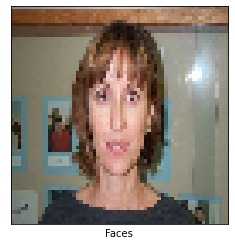

(64, 64, 3)


In [8]:
faces_images, faces_labels = load_images(PATH, "Faces")
imshow(faces_images[0], faces_labels[0])
print(faces_images[0].shape)

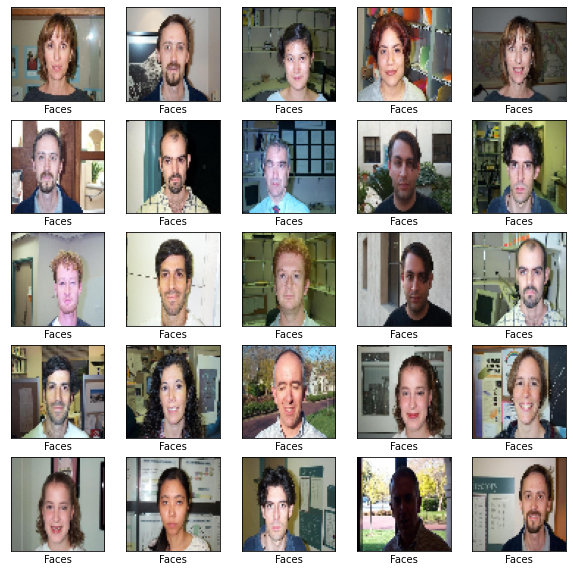

In [9]:
display_images(faces_images[:25], faces_labels[:25])

In [10]:
X_all, y_all = create_dataset(PATH)

Step verification:

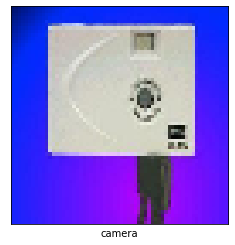

(64, 64, 3)


In [11]:
imshow(X_all[0], y_all[0])
print(X_all[0].shape)

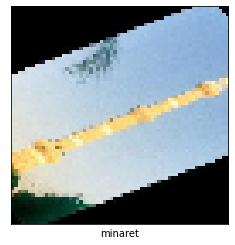

(64, 64, 3)


In [12]:
imshow(X_all[200], y_all[200])
print(X_all[200].shape)

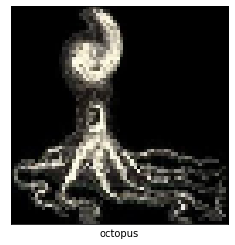

(64, 64, 3)


In [13]:
imshow(X_all[1000], y_all[1000])
print(X_all[1000].shape)

### 2) Standardize the images (5%)

**Note:** Some of these operations can be performed during step 1). If that's the case, don't do them again here.

Unify the images:

- Number and sequence of channels (RGB) if needed
- Images shape (e.g. $32 \times 32 \times 3$) - including channel convention (*channels_last* suggested)
- Standardization of pixel values, e.g. ($\frac{x - \mu}{\sigma}$) - calculate $\mu$ and $\sigma$ for the whole dataset, separately for each channel

**Step verification:**

Check what the image you selected in step 1) looks like now.

All images are rgb. That's because we use opencv to load them which loads all jpgs as 3 channeled, even when importing a grayscale image it will still make it three channeled.

Here is our function to standardize the images (formula from the task description)

In [14]:
def standardize_dataset(dataset):
    mean = np.mean(dataset, axis=(0,1,2))
    std = np.sqrt(((dataset - mean)**2).mean(axis=(0,1,2)))
    result = (dataset - mean) / std
    return result
standardized_X = standardize_dataset(X_all)

Step verification:

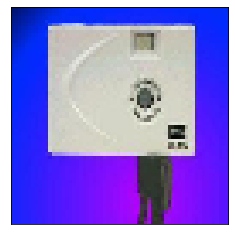

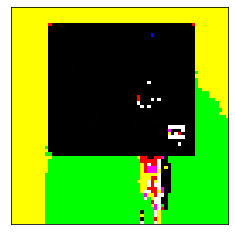

In [15]:
imshow(X_all[0])
imshow(standardized_X[0])

Let's not waste RAM though (fun fact, managing RAM proved to be the most difficult part of this project, sadly our personal gpu-free computers took ages for the model to train, so we had to stick to Colab)

In [16]:
del standardized_X
del X_all
del y_all

### 3) Divide the collection into Train and Test set (5%)


- Reduce the number of classes - filter the collection and leave images from ~15-25 classes, select those classes that have the largest number of examples. Make sure your collection is balanced (roughly the same number of samples for each class). You can do this by discarding classes that cause imbalance, or you can reduce the number of samples in larger classes.
- Randomly split the set into train (70%) and test (30%) set - X_train, X_test (images) and y_train, y_test (labels). (hint: check *sklearn.model_selection.train_test_split*)
- Make sure that the proportions of each class in both sets are more or less the same as in the whole set (hint: *stratify* parameter in *train_test_split*)
- Change labels in y vectors to one-hot encoding
- Ensure image and label collections are in the form of numpy.array

**Note:** After selecting a subset of classes, check what images contain these classes - are they appropriate for the classification problem? "BACKGROUND_Google" is probably not the best choice :)

**Step verification:**

- Check the shape of the X_train, X_test (images) and the y_train, y_test (labels)
- Check on the example images if the label is in the correct form
- Check how many samples from each class are in particular subsets (train and test) and whether the proportions are the same in both subsets

We have chosen to use 15 classes (following the idea of 'start slow and build up'). The classes choice was based on counting the number of images per class and choosing the 15 most populated ones (limit of representatives = 100 to avoid imbalanced distribution)

In [17]:
def get_n_categories(n = 15):
    categories = os.listdir(PATH)
    classes = dict()
    for category in categories:
        category_path = os.path.join(PATH, category)
        images_paths = os.listdir(category_path)
        classes[category] = len(images_paths)
    sorted_classes = sorted(classes.items(), key=lambda x:x[1], reverse=True)
    limit = sorted_classes[n][1]
    return [x[0] for x in sorted_classes[:n]], limit

In [18]:
new_categories, limit = get_n_categories()

In [19]:
new_categories

['airplanes',
 'Motorbikes',
 'Faces',
 'watch',
 'Leopards',
 'bonsai',
 'car_side',
 'ketch',
 'chandelier',
 'hawksbill',
 'grand_piano',
 'brain',
 'butterfly',
 'helicopter',
 'menorah']

In [20]:
X_15, y_15 = create_dataset(PATH, new_categories, limit = limit)

In [21]:
X_15.shape

(1290, 64, 64, 3)

In [22]:
X_15 = standardize_dataset(X_15)

In [23]:
X_15.shape

(1290, 64, 64, 3)

Now, would train test split from sklearn work? Yes, but we already had this function implemented in another project, and it would be a waste if we hadn't used it here. So here's our own function which creates the train, test and validation sets in a stratified manner and with user-based percentage of train/test/val data.

In [24]:
def distribute_train_test_val(X, y, test_split = 0.15, val_split = 0.15):
    classes = list(Counter(y).keys())
    number = list(Counter(y).values())
    n = len(classes)
    X_train, y_train, X_test, y_test, X_val, y_val = [],[],[],[],[],[]
    beg = 0
    for i in range(n):
        test_size = int(number[i] * test_split)
        val_size = int(number[i] * val_split)
        train_size = number[i] - test_size - val_size
        set_x = X[beg : beg + test_size]
        random.shuffle(set_x)
        set_y = y[beg : beg + test_size]
        X_test.extend(set_x)
        y_test.extend(set_y)
        beg += test_size
        set_x = X[beg : beg + val_size]
        random.shuffle(set_x)
        set_y = y[beg : beg + val_size]
        X_val.extend(set_x)
        y_val.extend(set_y)
        beg += val_size
        set_x = X[beg : beg + train_size]
        random.shuffle(set_x)
        set_y = y[beg : beg + train_size]
        X_train.extend(set_x)
        y_train.extend(set_y)
        beg += train_size
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_val = np.asarray(X_val)
    y_val = np.asarray(y_val)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
    return X_train, y_train, X_test, y_test, X_val, y_val

In [25]:
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X_15, y_15)

Step verification of the third point had to be done here, as OHE the data made it difficult

In [26]:
classes_train = list(Counter(y_train).keys())
number_train = list(Counter(y_train).values())
for i in range(len(classes_train)):
    print(classes_train[i], number_train[i])

airplanes 62
Motorbikes 62
Faces 62
watch 62
Leopards 62
bonsai 62
car_side 62
ketch 62
chandelier 62
hawksbill 62
grand_piano 62
brain 62
butterfly 62
helicopter 62
menorah 62


In [27]:
classes_test = list(Counter(y_test).keys())
number_test = list(Counter(y_test).values())
for i in range(len(classes_train)):
    print(classes_test[i], number_test[i])

airplanes 12
Motorbikes 12
Faces 12
watch 12
Leopards 12
bonsai 12
car_side 12
ketch 12
chandelier 12
hawksbill 12
grand_piano 12
brain 12
butterfly 12
helicopter 12
menorah 12


One-hot encoding the y's:

In [28]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [29]:
y_train.head()

,Faces,Leopards,Motorbikes,airplanes,bonsai,brain,butterfly,car_side,chandelier,grand_piano,hawksbill,helicopter,ketch,menorah,watch
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [30]:
mapping = y_train.columns

In [31]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

Step verification:

In [32]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(930, 64, 64, 3)
(180, 64, 64, 3)
(180, 64, 64, 3)
(930, 15)
(180, 15)
(180, 15)


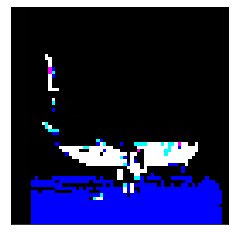

In [33]:
imshow(X_train[0])

y_train head showed that the first image is classified as airplanes, which is true.

### 4) Define the model (5%)

Suggestions (you should probably try different settings and choose the *best* one):

- Activation functions - *ReLU*
- At least 3 *Convolutional blocks* - (Conv2D, Activation, BatchNormalization, Dropout, MaxPooling2D); Conv2D - *kernel=(3,3)*, *padding='same'*; MaxPooling2D - *pool_size=(2,2)*
- Flatten layer
- At least 2 layers Fully-Connected (Dense)
- Output layer - Dense with number_of_classes outputs (remember to use softmax)

**Note:** You can add *Activation* as a separate layer or as *activation='relu'* parameter in Conv2D

**Step verification:**

Compile the model with *'adam'* optimizer, the Categorical Crossentropy as the loss function, and measure the accuracy value.

Here's our model (it's defined inside a function for further processing in part 2). We are very naive and have done everything as suggested (3 convolutional blocks etc. the description of our model is basically in the suggestions. Step verification is done inside the function.

In [34]:
input_shape = (img_size, img_size, 3)

In [35]:
def create_model(num_categories, conv_neurons = [32, 32, 32], dropout = [0.3, 0.3, 0.3], dense_neurons = [128, 200], activations = ['relu', 'relu', 'relu', 'relu', 'relu'], normalize_flag = True):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv2D(conv_neurons[0], kernel_size=(3, 3), padding='same', activation=activations[0]))
    if normalize_flag:
        model.add(BatchNormalization())
    model.add(Dropout(dropout[0]))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(conv_neurons[1], kernel_size=(3, 3), padding='same', activation=activations[1]))
    if normalize_flag:
        model.add(BatchNormalization())
    model.add(Dropout(dropout[1]))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(conv_neurons[2], kernel_size=(3, 3), padding='same', activation=activations[2]))
    if normalize_flag:
        model.add(BatchNormalization())
    model.add(Dropout(dropout[2]))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(dense_neurons[0], activation=activations[3]))
    model.add(Dense(dense_neurons[1], activation=activations[4]))

    model.add(Dense(num_categories, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [36]:
model = create_model(15)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       1

### 5) Train the model (5%)

Suggested hyperparameters:

- batch_size = 32
- epochs = 250 (or whatever you think is appropriate; first, just check if everything works on several epochs to save time)
- Monitor the value of measures for the test set
- Add [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop training when there is no improvement in accuracy for the test set within 5 consecutive epochs (you can first test the behavior for patience = 1)

**Step verification:**

After completing the learning process, show:

- Learning curves for loss_function and accuracy, changing over the epochs on train and test set
- Confusion matrix and calculate precision and recall for each class for test set
- Show few images from the test set, display the probabilities of assigning them to each class (at least two examples: one image example that was classified correctly and one which was classified incorrectly)

**Note:** Functions to display learning curves and confusion matrices based on the model will be useful in the Part 2.

Functions for diplaying learning curves, CM and CR:

In [37]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def get_predictions(model, X_test, y_test, mapping):
    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    pred_labels = np.argmax(predictions, axis = 1)
    y_labels = np.asarray(y_test)
    y_labels = np.argmax(y_labels, axis = 1)
    labels = []
    for i in range(25):
        labels.append(str(mapping[pred_labels[i]]) + " " + str(mapping[y_labels[i]]))
    X = np.asarray(X_test[:25])
    display_images(X, labels)
    return y_labels, pred_labels
    
def display_confusion_matrix(y_labels, pred_labels, mapping):
    cm = confusion_matrix(y_labels, pred_labels)
    ax = plt.axes()
    sns.heatmap(cm, annot=True, 
            annot_kws={"size": 5}, 
            xticklabels=mapping, 
            yticklabels=mapping, ax = ax)
    ax.set_title('Confusion matrix')
    plt.show()
    cr = classification_report(y_labels, pred_labels, target_names=mapping)
    return cr

def plot_all(history, model, X_test, y_test, mapping):
    plot_accuracy(history)
    plot_loss(history)
    y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
    return display_confusion_matrix(y_labels, pred_labels, mapping)

Here's an interesting addition that differs from the suggestions - we decided to use and ImageDataGenerator (our NN was overfitting and after scouring multiple stackoverflow posts, we found one that said this could be a solution to our problems - now it still overfits, but not as fast as it used to before).

In [38]:
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

We have decided to use the recommended formulas for steps_per_epoch and validation_steps, set the patience to 10 and told EarlyStopping to restore to the best weights achieved (all to avoid our overfitting problem). 

In [56]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=10,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])

Epoch 1/250
29/29 [==============================] - 2s 51ms/step - loss: 2.5752 - accuracy: 0.1882 - val_loss: 2.5300 - val_accuracy: 0.2444
Epoch 2/250
29/29 [==============================] - 1s 46ms/step - loss: 1.9258 - accuracy: 0.3820 - val_loss: 2.7731 - val_accuracy: 0.1278
Epoch 3/250
29/29 [==============================] - 1s 46ms/step - loss: 1.6658 - accuracy: 0.4752 - val_loss: 3.4102 - val_accuracy: 0.1111
Epoch 4/250
29/29 [==============================] - 1s 44ms/step - loss: 1.3882 - accuracy: 0.5579 - val_loss: 3.7789 - val_accuracy: 0.1167
Epoch 5/250
29/29 [==============================] - 1s 47ms/step - loss: 1.3080 - accuracy: 0.5857 - val_loss: 4.4518 - val_accuracy: 0.1111
Epoch 6/250
29/29 [==============================] - 1s 46ms/step - loss: 1.0758 - accuracy: 0.6682 - val_loss: 4.2541 - val_accuracy: 0.1556
Epoch 7/250
29/29 [==============================] - 1s 43ms/step - loss: 1.0641 - accuracy: 0.6481 - val_loss: 4.7553 - val_accuracy: 0.1556
Epoch 

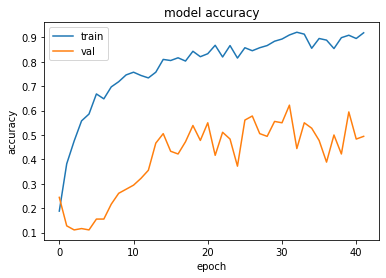

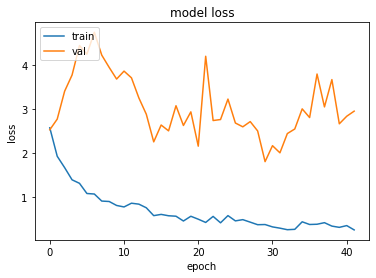

6/6 [==============================] - 0s 4ms/step


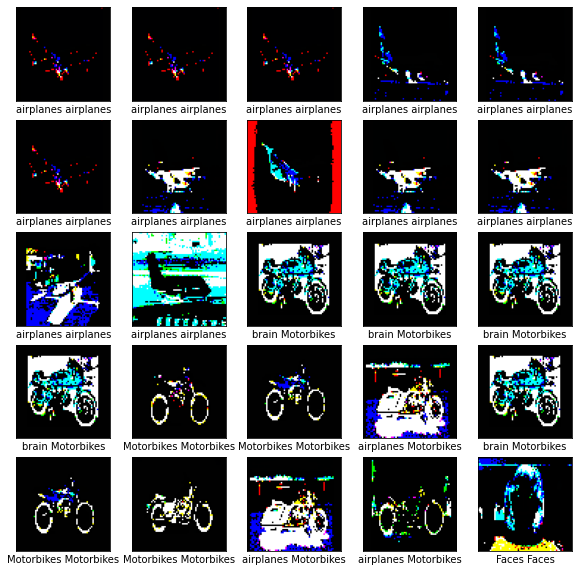

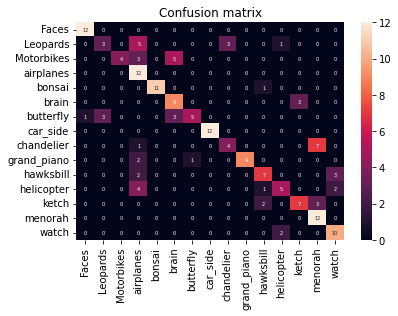

In [57]:
cr = plot_all(history, model, X_test, y_test, mapping)

In [41]:
print(cr)

              precision    recall  f1-score   support

       Faces       0.20      0.17      0.18        12
    Leopards       0.52      0.92      0.67        12
  Motorbikes       0.29      0.50      0.36        12
   airplanes       0.18      0.17      0.17        12
      bonsai       0.00      0.00      0.00        12
       brain       0.00      0.00      0.00        12
   butterfly       0.25      0.42      0.31        12
    car_side       0.90      0.75      0.82        12
  chandelier       0.00      0.00      0.00        12
 grand_piano       0.48      0.92      0.63        12
   hawksbill       0.64      0.58      0.61        12
  helicopter       0.11      0.08      0.10        12
       ketch       0.45      0.75      0.56        12
     menorah       0.00      0.00      0.00        12
       watch       0.42      0.42      0.42        12

    accuracy                           0.38       180
   macro avg       0.30      0.38      0.32       180
weighted avg       0.30   

### 6) Save the model to disk (5%)


- Prepare 2 functions - for saving the model and for loading the model
- Model structure should be saved as JSON file, model parameters in HDF5 file

**Step verification:**

Checking the operation of both functions by:

- Save the model
- Load the model
- Make predictions on the loaded model for the test set
- Display the confusion matrix for the test set and compare it with the matrix obtained in the previous step to see if saving and loading worked properly

In [58]:
!touch model0.json
!touch weights0.h5

In [59]:
def save_model(model, model_path, weights_path):
    model_json = model.to_json()
    with open(model_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weights_path)

In [60]:
def load_model(model_path, weights_path):
    with open((model_path), "r") as json_file:
        model = tf.keras.models.model_from_json(json_file.read())
    model.load_weights(weights_path)
    return model

Step verification:

In [61]:
save_model(model, '/content/model0.json', '/content/weights0.h5')

In [62]:
model_json = load_model('/content/model0.json', '/content/weights0.h5')

In [63]:
model_json.compile(optimizer='adam', 
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [64]:
test_loss = model_json.evaluate(X_test, y_test)
test_loss

6/6 [==============================] - 0s 5ms/step - loss: 2.0159 - accuracy: 0.6778


[2.0159404277801514, 0.6777777671813965]

6/6 [==============================] - 0s 4ms/step


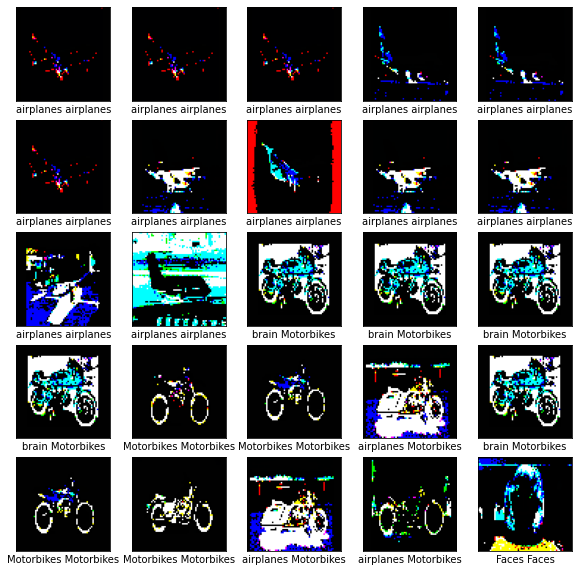

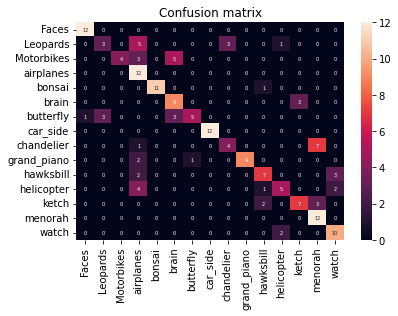

'              precision    recall  f1-score   support\n\n       Faces       0.92      1.00      0.96        12\n    Leopards       0.50      0.25      0.33        12\n  Motorbikes       1.00      0.33      0.50        12\n   airplanes       0.41      1.00      0.59        12\n      bonsai       1.00      0.92      0.96        12\n       brain       0.53      0.75      0.62        12\n   butterfly       0.83      0.42      0.56        12\n    car_side       1.00      1.00      1.00        12\n  chandelier       0.57      0.33      0.42        12\n grand_piano       1.00      0.75      0.86        12\n   hawksbill       0.64      0.58      0.61        12\n  helicopter       0.62      0.42      0.50        12\n       ketch       0.70      0.58      0.64        12\n     menorah       0.55      1.00      0.71        12\n       watch       0.67      0.83      0.74        12\n\n    accuracy                           0.68       180\n   macro avg       0.73      0.68      0.67       180\nweigh

In [65]:
y_labels, pred_labels = get_predictions(model_json, X_test, y_test, mapping)
display_confusion_matrix(y_labels, pred_labels, mapping)

### 7) Summary of the Part 1 - describe your observations (10%)

Describe your observations on the tasks performed. Supporting questions:

- What kind of modifications have you made? Why? (*Describe, if you made any*)
- What results have you achieved?
- Is the underfitting or overfitting of the model visible? If so, what are your suggestions for solving this problem?
- Which class(es) the model had a trouble with? Which were the easiest for it? Which pair of classes were most often confused with each other? Can you guess why?
- What opportunities do you see for improvement?

**Step verification:**

Use Markdowns to describe your conclusions or put them into the report.

The summary will be performed on our best result, allow me to load in the model

In [66]:
model_json = load_model('/content/model3.json', '/content/weights3.h5')

In [67]:
model_json.compile(optimizer='adam', 
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [68]:
test_loss = model_json.evaluate(X_test, y_test)
test_loss

6/6 [==============================] - 0s 5ms/step - loss: 2.0159 - accuracy: 0.6778


[2.0159404277801514, 0.6777777671813965]

6/6 [==============================] - 0s 3ms/step


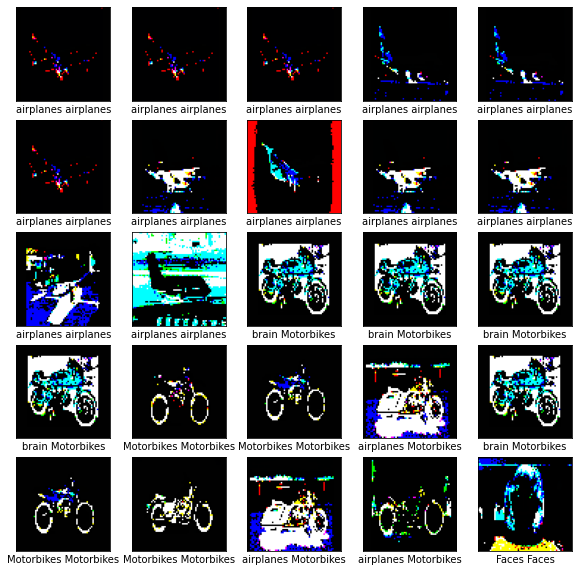

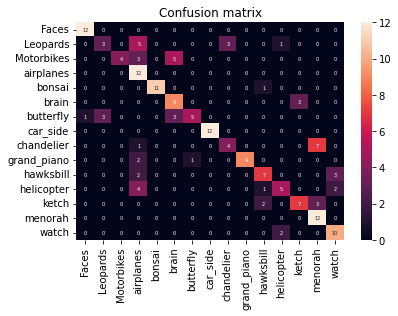

In [69]:
y_labels, pred_labels = get_predictions(model_json, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

In [70]:
print(cr)

              precision    recall  f1-score   support

       Faces       0.92      1.00      0.96        12
    Leopards       0.50      0.25      0.33        12
  Motorbikes       1.00      0.33      0.50        12
   airplanes       0.41      1.00      0.59        12
      bonsai       1.00      0.92      0.96        12
       brain       0.53      0.75      0.62        12
   butterfly       0.83      0.42      0.56        12
    car_side       1.00      1.00      1.00        12
  chandelier       0.57      0.33      0.42        12
 grand_piano       1.00      0.75      0.86        12
   hawksbill       0.64      0.58      0.61        12
  helicopter       0.62      0.42      0.50        12
       ketch       0.70      0.58      0.64        12
     menorah       0.55      1.00      0.71        12
       watch       0.67      0.83      0.74        12

    accuracy                           0.68       180
   macro avg       0.73      0.68      0.67       180
weighted avg       0.73   

On the train set the model achieved 
loss: 0.2850 accuracy: 0.9098, on the validation set it was loss: 2.0039 accuracy: 0.6222, while on the independent test loss: 2.0159 accuracy: 0.6778. Overall the result isn't bad, but it's not great either. We will experiment with the parameters to see if we can make it better in the later part of the report.

The main modifications we made are related to the dataset - Caltech-101. It is sadly a dataset that is quite unbalanced with some redundant folders. We have removed such folders (Faces_easy and BACKGROUND GOOGLE) to avoid feeding our model data which is unimportant (Faces_easy and Faces are basically the same thing, BACKGROUND GOOGLE had no pattern to it). When it comes to balancing out, we have set a limit when it comes to using a class (100 representatives) and have used ImageDataGenerator from the keras library.

The model is clearly overfitting. We've done everything we could think of to stop the process but our best attempts only slowed it. If we had more data we would feed the model, but for now we've done our best. We used BatchNormalization, Dropout, MaxPooling to conquer this problem. We also put saving the best weights in EarlyStopping.

The categories that were classified correctly 100% of the time are Faces, menorah, airplanes and car_side. Then bonsai was classified correctly 92% of time, while watch achieved a 83%. There were no classes which were classified incorrectly 100%. The lowest classification rate was achieved by Leopard - a whooping 25%. It was misclassified as and airplane 5 times.A conclusion we've drawn from the confusion matrix is that we suspect that initially all images were classified as airplanes - since that's were a lot of classes were mistakenly put, some completely unrelated like Leopards and Grand_piano.

Firstly, we think that the number of classes is too high - since the limit is set based on the lowest number of representatives for the least populated class, here we got only 80 images per class. We hope that tuning dropout will provide some improvement. We also wanna try some different preprocessing approaches - maybe standardizing just isn't the best option for our dataset and therefore using a different function will yield better result (or maybe not using one at all). 

## Part 2 - Experimental comparative analysis

The purpose of the Part 2 is to examine the dependence of the quality of the resulting model on factors such as hyperparameters, model structure, number of training data, number of decision classes, etc. Below is a suggestion of simple tasks - most of them consist of a simple experiment to compare several models that differ in some detail.

### Before you start

- You don't have to complete all of the tasks, you can choose the issues that seem interesting to you. You can also suggest your own ideas for the experiment definition (in this case - consult with the teacher). As mentioned above, each task is worth $20\%$ of the project grade (the value of the last task is doubled, because it requires much more effort). Assuming you've completed the Part 1, as you may have already calculated:
  - You should complete at least 1 task *almost* correctly to pass ($40\% + 20\% = 60\% \geq 50\%$)
  - You should complete at least 3 tasks correctly to get the maximum score ($40\% + 3 \cdot 20\% = 100\%$)
  
  Of course, you can complete more than 3 tasks, then the extra points will ensure that even if one of the tasks is not completely correct, you still have an opportunity to get $100\%$.
- It is possible to combine tasks into one large experiment, because most of the tasks consist of comparing models that differ in one aspect. Thus, instead of conducting individual experiments, you can perform [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) and modify a set of several parameters simultaneously. However, it is important to remember that the conclusions about a given experiment should take into account observations about each of the subtasks (different aspects).
- If you perform several experiments one after another, take into account the conclusions from the previous ones. For example, if in the first experiment you are testing the quality of different models, and in the second you want to check the effect of the dataset size on the results, then in the second task you should use the conclusions of the first experiment (i.e. choose the model that performed better). However, if applying the conclusions of the first study will significantly increase the time of the next experiment, you do not need to apply them to subsequent tasks.
- If you have not already done so, modify the functions in the Part 1 so that they can be used for the following subtasks. You can also rewrite the code and adapt it to the requirements of the tasks.
- Pay attention to the last task - it is more complicated and requires you to find additional information, therefore it is worth 50%.

### Collecting experimental data

In addition to implementing the code and running experiments to carry out a given task, you must draw conclusions about the results. In that case, it may be helpful to collect the following information about the compared models:

- The number of network parameters (as a measure of the memory complexity of the model)
- Training time (as a measure of the time complexity of the model)
- Values of the obtained quality measures (loss function, accuracy - maybe other measures should be considered?) for train and  test sets in the resulting model
- Values of the loss function and measures in successive epochs (learning curves - can be useful in the context of discussing overfitting, optimization speed and model stability while learning)
- Confusion matrix (mainly in the test set, but maybe the train set matrix will help to better understand the learning process)
- Precision and recall (maybe some other measures?) for decision classes (assessment of classification difficulty for individual classes; comparison of the precision-recall curve between classes and between models)
- Display some examples that were correctly and incorrectly classified by one or more models (example-based explanation)

In general, there are many possibilities to visualize data, to compare models with each other and draw conclusions from it. Only some suggestions are visible above, it is up to you what and how you decide to show in your conclusions and observations.

### Task description

Each of the following tasks assumes the implementation of an appropriate code that will perform a given experiment - and therefore it will probably modify the dataset or model (its structure or hyperparameters). After implementing the experiment, write:
- Which task did you choose?
- What are the differences between the models or data sets you tested?

After obtaining the results for the compared models, datasets or any other aspect, describe your observations and conclusions about the experiment. Observations may in particular concern:
- The overall predictive ability of the model - which model is better, which model is worse, maybe one is better with class X and one with class Y, etc.
- The impact of the changes made on overfitting and underfitting
- Comparison of the duration of learning, the complexity of the model
- Assessment of whether it was profitable to make such a modification (or indicate the best option in your opinion)
- Learning curve shape - in which model the optimization was faster, whether the loss function and accuracy on the test set decreased steadily, were there any deviations, etc.
- Sample images where one model is better than the other - try to answer *why?*
- If something is not working well, write about your assumptions, why it failed and what could be changed. If you want, try the changes you suggest and also describe whether it has brought the desired effect.

In general, it is worth describing everything that you find interesting in the context of the specific task. The description of the conclusions should be included in Markdown(s) (or in the report if you want to prepare one).

#### Task 2) The impact of the number of decision classes on the results (e.g. 10, 25, 50, all of the available classes)

2 classes

Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.3888 - accuracy: 0.9459


3/3 [==============================] - 0s 6ms/step


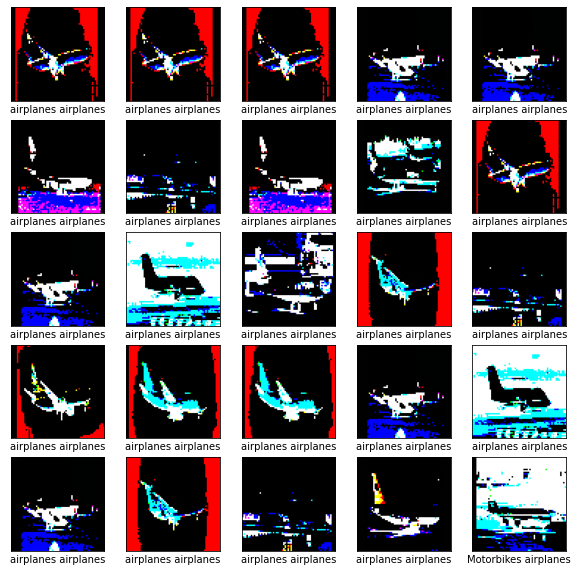

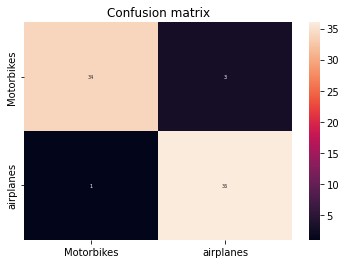

In [74]:
num_of_classes = 2
new_categories, limit = get_n_categories(num_of_classes)
if limit > 250:
    limit = 250
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)
model = create_model(num_of_classes)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    verbose = 0,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=10,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])
y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

5 classes

Epoch 1/250
14/14 [==============================] - 2s 66ms/step - loss: 1.1839 - accuracy: 0.5550 - val_loss: 1.2925 - val_accuracy: 0.5789
Epoch 2/250
14/14 [==============================] - 1s 45ms/step - loss: 0.6865 - accuracy: 0.7433 - val_loss: 1.1642 - val_accuracy: 0.5789
Epoch 3/250
14/14 [==============================] - 1s 44ms/step - loss: 0.3949 - accuracy: 0.8445 - val_loss: 1.0394 - val_accuracy: 0.6947
Epoch 4/250
14/14 [==============================] - 1s 48ms/step - loss: 0.5039 - accuracy: 0.8254 - val_loss: 1.0294 - val_accuracy: 0.6421
Epoch 5/250
14/14 [==============================] - 1s 44ms/step - loss: 0.4661 - accuracy: 0.8254 - val_loss: 1.1407 - val_accuracy: 0.5474
Epoch 6/250
14/14 [==============================] - 1s 43ms/step - loss: 0.4384 - accuracy: 0.8349 - val_loss: 1.4451 - val_accuracy: 0.4316
Epoch 7/250
14/14 [==============================] - 1s 44ms/step - loss: 0.2569 - accuracy: 0.9187 - val_loss: 2.0125 - val_accuracy: 0.3368
Epoch 

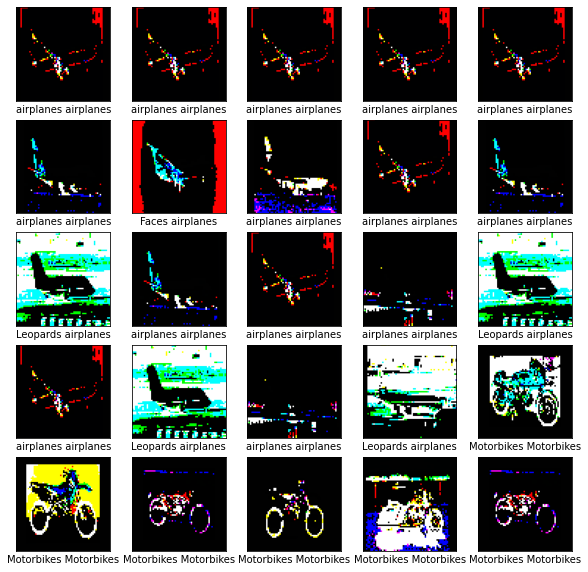

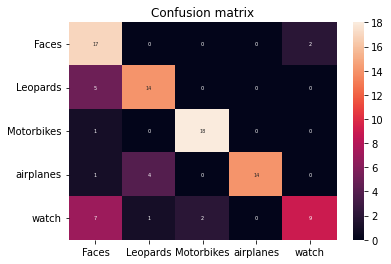

In [82]:
num_of_classes = 5
new_categories, limit = get_n_categories(num_of_classes)
if limit > 250:
    limit = 250
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)
model = create_model(num_of_classes)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=10,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])
y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

10 classes

Epoch 1/250
22/22 [==============================] - 2s 56ms/step - loss: 2.1332 - accuracy: 0.2861 - val_loss: 2.1428 - val_accuracy: 0.2143
Epoch 2/250
22/22 [==============================] - 1s 46ms/step - loss: 1.3550 - accuracy: 0.5457 - val_loss: 2.0991 - val_accuracy: 0.1429
Epoch 3/250
22/22 [==============================] - 1s 44ms/step - loss: 1.0635 - accuracy: 0.6445 - val_loss: 2.2322 - val_accuracy: 0.1429
Epoch 4/250
22/22 [==============================] - 1s 44ms/step - loss: 0.8511 - accuracy: 0.7286 - val_loss: 2.2972 - val_accuracy: 0.1429
Epoch 5/250
22/22 [==============================] - 1s 43ms/step - loss: 0.7714 - accuracy: 0.7316 - val_loss: 2.5286 - val_accuracy: 0.1857
Epoch 6/250
22/22 [==============================] - 1s 45ms/step - loss: 0.6683 - accuracy: 0.7876 - val_loss: 2.8745 - val_accuracy: 0.2143
Epoch 7/250
22/22 [==============================] - 1s 44ms/step - loss: 0.6606 - accuracy: 0.7788 - val_loss: 3.1792 - val_accuracy: 0.1857
Epoch 

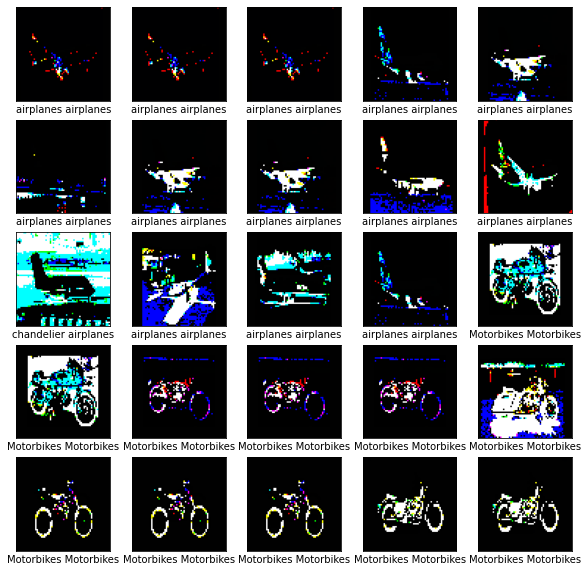

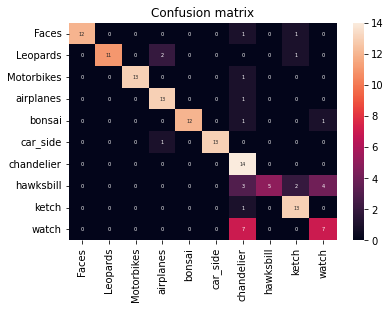

In [83]:
num_of_classes = 10
new_categories, limit = get_n_categories(num_of_classes)
if limit > 250:
    limit = 250
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)
model = create_model(num_of_classes)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=10,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])
y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

20 classes

Epoch 1/250
38/38 [==============================] - 3s 51ms/step - loss: 2.8578 - accuracy: 0.1538 - val_loss: 2.8236 - val_accuracy: 0.1958
Epoch 2/250
38/38 [==============================] - 2s 45ms/step - loss: 2.2268 - accuracy: 0.3434 - val_loss: 2.9719 - val_accuracy: 0.0917
Epoch 3/250
38/38 [==============================] - 2s 44ms/step - loss: 1.8998 - accuracy: 0.4192 - val_loss: 4.1745 - val_accuracy: 0.0792
Epoch 4/250
38/38 [==============================] - 2s 44ms/step - loss: 1.7060 - accuracy: 0.5093 - val_loss: 4.9434 - val_accuracy: 0.0750
Epoch 5/250
38/38 [==============================] - 2s 45ms/step - loss: 1.4986 - accuracy: 0.5429 - val_loss: 5.1863 - val_accuracy: 0.1500
Epoch 6/250
38/38 [==============================] - 2s 44ms/step - loss: 1.3960 - accuracy: 0.5758 - val_loss: 5.2903 - val_accuracy: 0.1583
Epoch 7/250
38/38 [==============================] - 2s 44ms/step - loss: 1.2244 - accuracy: 0.6170 - val_loss: 4.4924 - val_accuracy: 0.2250
Epoch 

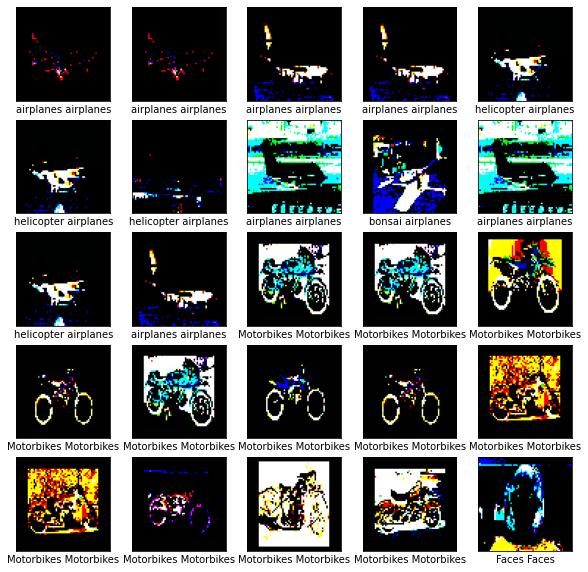

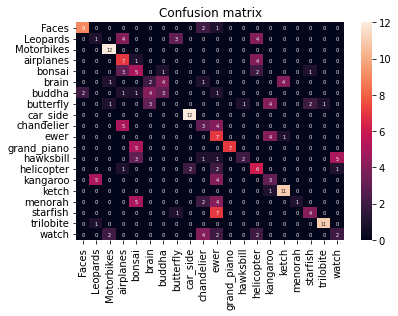

In [86]:
num_of_classes = 20
new_categories, limit = get_n_categories(num_of_classes)
if limit > 250:
    limit = 250
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)
model = create_model(num_of_classes)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=10,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])
y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

50 classes

Epoch 1/250
67/67 [==============================] - 4s 49ms/step - loss: 3.8663 - accuracy: 0.0661 - val_loss: 4.2330 - val_accuracy: 0.0425
Epoch 2/250
67/67 [==============================] - 3s 44ms/step - loss: 3.3152 - accuracy: 0.1676 - val_loss: 5.4132 - val_accuracy: 0.0250
Epoch 3/250
67/67 [==============================] - 3s 43ms/step - loss: 2.9809 - accuracy: 0.2342 - val_loss: 7.4410 - val_accuracy: 0.0225
Epoch 4/250
67/67 [==============================] - 3s 44ms/step - loss: 2.7380 - accuracy: 0.2795 - val_loss: 6.8443 - val_accuracy: 0.0725
Epoch 5/250
67/67 [==============================] - 3s 44ms/step - loss: 2.5037 - accuracy: 0.3338 - val_loss: 6.1258 - val_accuracy: 0.0925
Epoch 6/250
67/67 [==============================] - 3s 45ms/step - loss: 2.2864 - accuracy: 0.3829 - val_loss: 5.6640 - val_accuracy: 0.0950
Epoch 7/250
67/67 [==============================] - 3s 44ms/step - loss: 2.1542 - accuracy: 0.4112 - val_loss: 5.7749 - val_accuracy: 0.1425
Epoch 

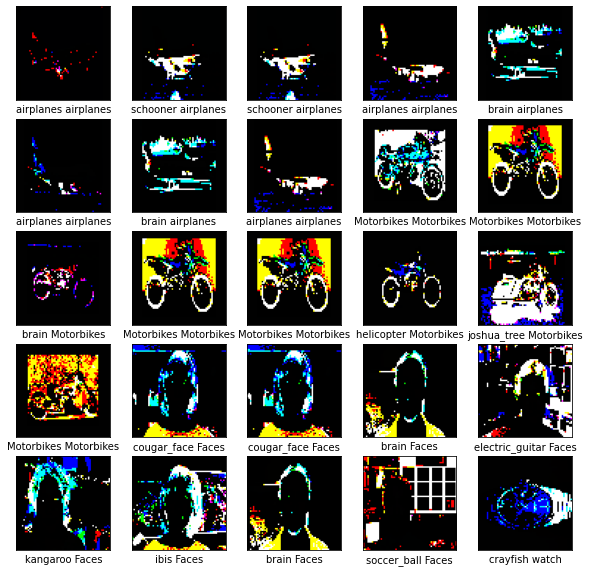

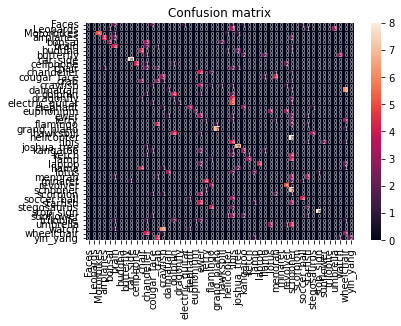

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
num_of_classes = 50
new_categories, limit = get_n_categories(num_of_classes)
if limit > 250:
    limit = 250
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)
model = create_model(num_of_classes)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, shuffle=True), 
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=20,
                            restore_best_weights=True,
                            verbose = 1
                        )
                    ])
y_labels, pred_labels = get_predictions(model, X_test, y_test, mapping)
cr = display_confusion_matrix(y_labels, pred_labels, mapping)

|            | Loss | Accuracy |
|------------|------|----------|
| 2 classes  | 0.39 | 0.95     |
| 5 classes  | 0.97 | 0.76     |
| 10 classes | 1.08 | 0.81     |
| 20 classes | 2.91 | 0.45     |
| 50 classes | 9.19 | 0.25     |

Well, the model got much better accuracy scores when there were less classes to predict, as we hoped. The results dissapointed us a bit though, as we have found that it didn't improve quite as much as we hoped.

The conclusion we have drawn from this experiment is something that we already were suspecting - the model tends to assign all elements to one class (while also having a class that it very rarely assigns to, but only in case of more than 5 classes).

There's also the problem that it learns randomly and converges very fast - we thought that maybe if the patience was bigger this problem would be solved, but we have found that is not the case - we have increased the patience in case of 50 classes because it made sense.

#### Task 3) Compare the models without and with Dropout with different rates (e.g. 0.1, 0.2, 0.5)

In [89]:
new_categories, limit = get_n_categories(15)
X, y = create_dataset(PATH, new_categories, limit = limit)
X = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_test)
mapping = y_train.columns
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_test)

In [90]:
drop_values = [0.1, 0.2, 0.3, 0.4, 0.5]
all_dropouts = list(itertools.combinations_with_replacement(drop_values, 3))

In [91]:
accu_loss_dropout = []
for dropout in all_dropouts:
    model = create_model(15, dropout = list(dropout))
    history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
    results = model.evaluate(X_test, y_test, batch_size=32)
    accu_loss_dropout.append(results)

Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping
6/6 [==============================] - 0s 5ms/step - loss: 0.9045 - accuracy: 0.7222
Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
6/6 [==============================] - 0s 4ms/step - loss: 0.9998 - accuracy: 0.7778
Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
6/6 [==============================] - 0s 5ms/step - loss: 1.0017 - accuracy: 0.7389
Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
6/6 [==============================] - 0s 5ms/step - loss: 1.1853 - accuracy: 0.8167
Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
6/6 [==============================] - 0s 5ms/step - loss: 1.1139 - accuracy: 0.6722
Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
6/6 [==============================] - 0s 65ms/step - loss: 1.252

In [95]:
bar_dropouts_accu = dict()
bar_dropouts_loss = dict()
for i in range(len(accu_loss_dropout)):
    bar_dropouts_accu[all_dropouts[i]] = accu_loss_dropout[i][1]
    bar_dropouts_loss[all_dropouts[i]] = accu_loss_dropout[i][0]

We encountered an error, cause matplotlib only took into account displaying 32 elements on a bar chart, and we have 35

In [98]:
def splitlist(input_list):
    n = len(input_list)//2
    first_half = input_list[:n]
    sec_half = input_list[n:]
    return first_half,sec_half

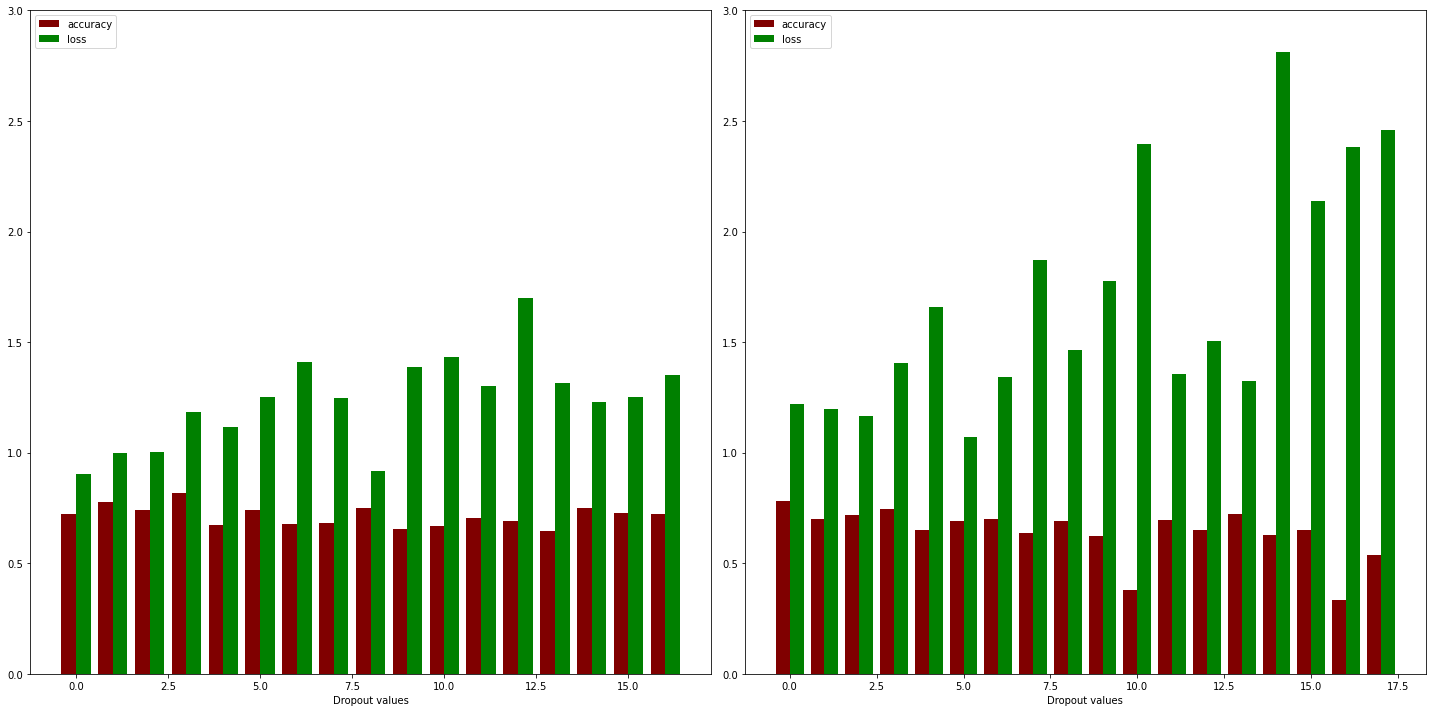

In [118]:
x1, x2 = splitlist(range(0, len(all_dropouts)))
y1_a, y2_a = splitlist(list(bar_dropouts_accu.values()))
y1_l, y2_l = splitlist(list(bar_dropouts_loss.values()))

fig = plt.figure(figsize = (20, 10))

X_axis = np.arange(len(x1))

plt.subplot(1, 2, 1)
plt.bar(X_axis - 0.2, y1_a, color ='maroon', width = 0.4, label="accuracy")
plt.bar(X_axis + 0.2, y1_l, color ='green', width = 0.4, label="loss")
plt.xlabel("Dropout values")
plt.legend(loc="upper left")
plt.ylim(0, 3)

X_axis = np.arange(len(x2))

plt.subplot(1, 2, 2)
plt.bar(X_axis - 0.2, y2_a, color ='maroon', width = 0.4, label="accuracy")
plt.bar(X_axis + 0.2, y2_l, color ='green', width = 0.4,  label="loss")
plt.xlabel("Dropout values")
plt.legend(loc="upper left")
plt.ylim(0, 3)


plt.tight_layout()
plt.show()

Looking at the plots, the best accuracy to loss ratio was achieved by dropout no. 8. Let's peak at it.

In [119]:
all_dropouts[8]

(0.1, 0.2, 0.5)

This is a nice conclusion and it might help with overfitting - low values in the beginning allow the model to learn sth, and then comes the 0.5 dropout to cut out all the unimportant parts.

In [120]:
best_dropout = all_dropouts[8]

We didn't use ImageGenerator here to make the test more accurate (less random and more reliable).

#### Task 5) Compare the models without and with batch normalization

In [124]:
accu_loss_batch = []
for flag in [True, False]:
    model = create_model(15, normalize_flag = flag, dropout = best_dropout)
    history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
    results = model.evaluate(X_test, y_test, batch_size=32)
    accu_loss_batch.append(results)

Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
6/6 [==============================] - 0s 4ms/step - loss: 1.6829 - accuracy: 0.6667
Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping
6/6 [==============================] - 0s 5ms/step - loss: 1.0587 - accuracy: 0.7222


In [126]:
accu_loss_batch

[[1.6828618049621582, 0.6666666865348816],
 [1.0586804151535034, 0.7222222089767456]]

We didn't use ImageGenerator here as well, for the same reasons as before. What's surprising is that BatchNormalization actually seemed to worsen the models state. That was entirely unexpected, but we kept it in mind and moved on to the next task.

#### Task 6) Compare the models for different preprocessing approaches (perform operations separately per channel):
- Raw data - $X$
- Subtracting the mean ($X - \mu$)
- Normalization ($\frac{X - min}{max - min}$)
- Standardization ($\frac{X - \mu}{\sigma}$)

In [127]:
def substracting_dataset(dataset):
    mean = np.mean(dataset, axis=(0,1,2))
    result = dataset - mean
    return result

In [128]:
def normalize_dataset(dataset):
    mini = np.min(dataset, axis=(0,1,2))
    maxi = np.max(dataset, axis=(0,1,2))
    result = (dataset - mini) / (maxi - mini)
    return result

In [129]:
new_categories, limit = get_n_categories(10)
X, y = create_dataset(PATH, new_categories, limit = limit)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
mapping = y_train.columns
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping


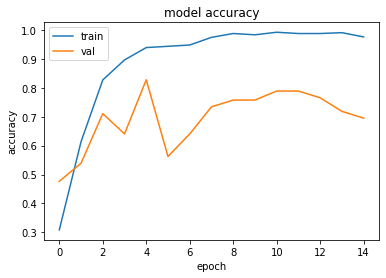

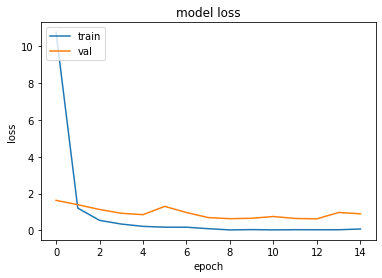

5/5 [==============================] - 0s 4ms/step


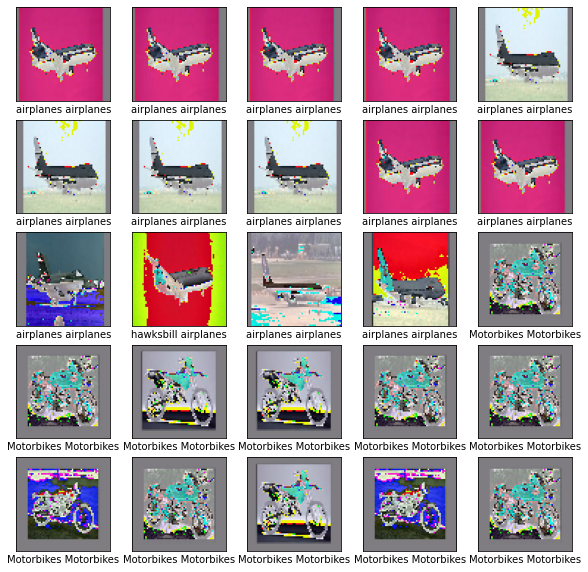

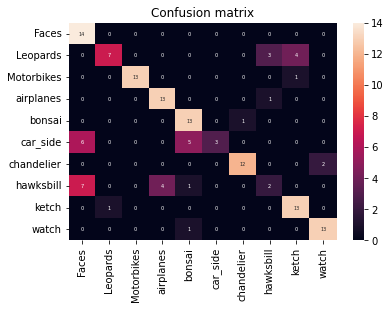

In [139]:
model = create_model(10, normalize_flag = False, dropout = best_dropout)
history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
cr = plot_all(history, model, X_test, y_test, mapping)

In [140]:
print(cr)

              precision    recall  f1-score   support

       Faces       0.52      1.00      0.68        14
    Leopards       0.88      0.50      0.64        14
  Motorbikes       1.00      0.93      0.96        14
   airplanes       0.76      0.93      0.84        14
      bonsai       0.65      0.93      0.76        14
    car_side       1.00      0.21      0.35        14
  chandelier       0.92      0.86      0.89        14
   hawksbill       0.33      0.14      0.20        14
       ketch       0.72      0.93      0.81        14
       watch       0.87      0.93      0.90        14

    accuracy                           0.74       140
   macro avg       0.77      0.74      0.70       140
weighted avg       0.77      0.74      0.70       140



In [132]:
X_substracted = substracting_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X_substracted, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


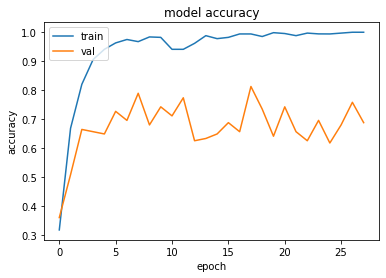

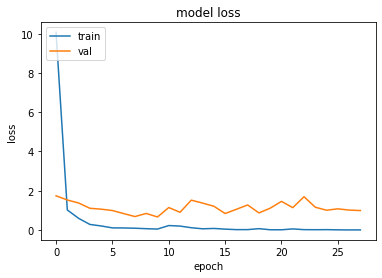

5/5 [==============================] - 0s 4ms/step


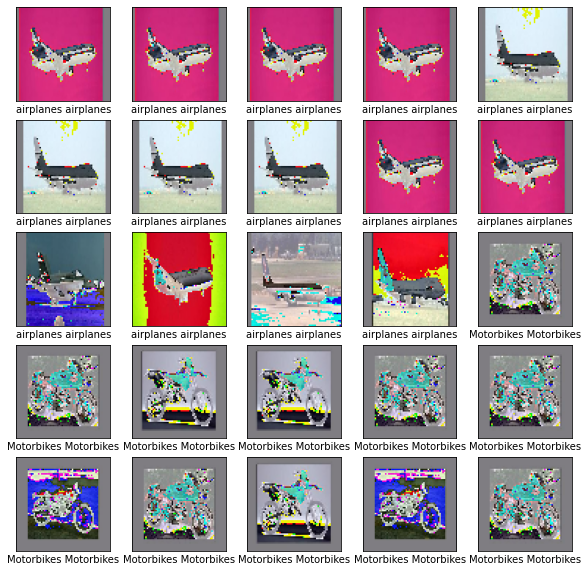

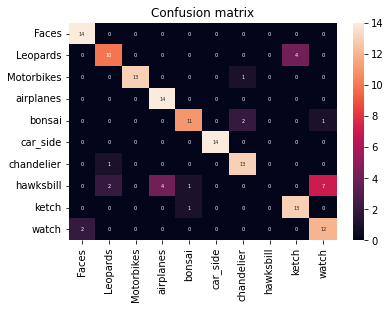

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
model = create_model(10, normalize_flag = False, dropout = best_dropout)
history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
cr = plot_all(history, model, X_test, y_test, mapping)

In [138]:
print(cr)

              precision    recall  f1-score   support

       Faces       0.88      1.00      0.93        14
    Leopards       0.77      0.71      0.74        14
  Motorbikes       1.00      0.93      0.96        14
   airplanes       0.78      1.00      0.88        14
      bonsai       0.85      0.79      0.81        14
    car_side       1.00      1.00      1.00        14
  chandelier       0.81      0.93      0.87        14
   hawksbill       0.00      0.00      0.00        14
       ketch       0.76      0.93      0.84        14
       watch       0.60      0.86      0.71        14

    accuracy                           0.81       140
   macro avg       0.74      0.81      0.77       140
weighted avg       0.74      0.81      0.77       140



In [143]:
X_normalized = normalize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X_normalized, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping


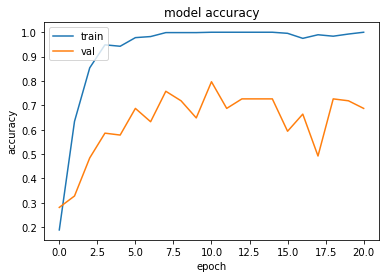

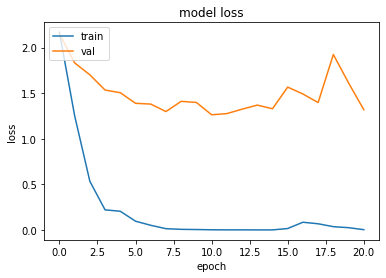

5/5 [==============================] - 0s 5ms/step


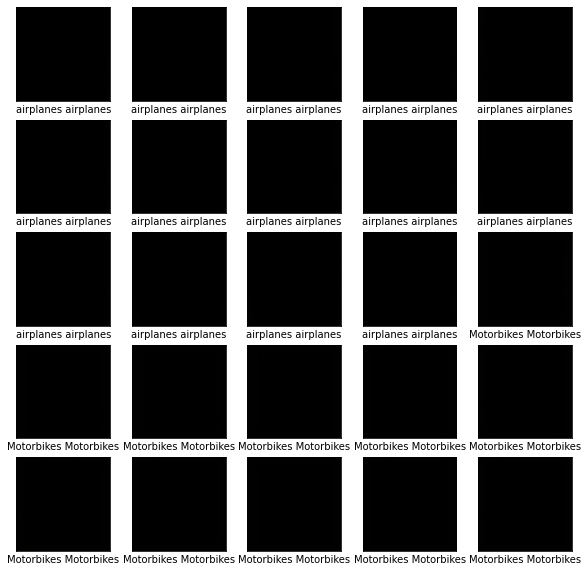

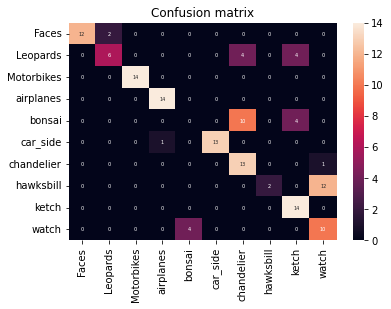

In [145]:
model = create_model(10, normalize_flag = False, dropout = best_dropout)
history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
cr = plot_all(history, model, X_test, y_test, mapping)

In [146]:
print(cr)

              precision    recall  f1-score   support

       Faces       1.00      0.86      0.92        14
    Leopards       0.75      0.43      0.55        14
  Motorbikes       1.00      1.00      1.00        14
   airplanes       0.93      1.00      0.97        14
      bonsai       0.00      0.00      0.00        14
    car_side       1.00      0.93      0.96        14
  chandelier       0.48      0.93      0.63        14
   hawksbill       1.00      0.14      0.25        14
       ketch       0.64      1.00      0.78        14
       watch       0.43      0.71      0.54        14

    accuracy                           0.70       140
   macro avg       0.72      0.70      0.66       140
weighted avg       0.72      0.70      0.66       140



In [147]:
X_standardized = standardize_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X_standardized, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping


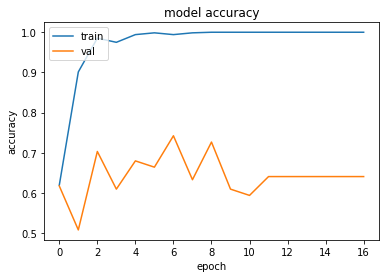

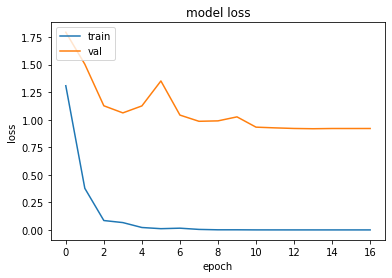

5/5 [==============================] - 0s 3ms/step


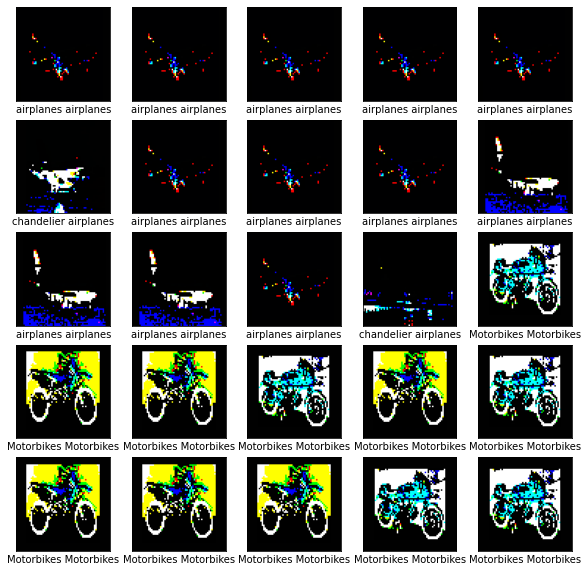

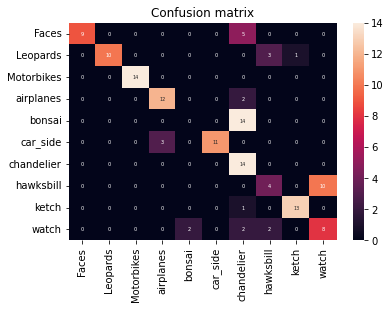

In [148]:
model = create_model(10, normalize_flag = False, dropout = best_dropout)
history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
cr = plot_all(history, model, X_test, y_test, mapping)

In [149]:
print(cr)

              precision    recall  f1-score   support

       Faces       1.00      0.64      0.78        14
    Leopards       1.00      0.71      0.83        14
  Motorbikes       1.00      1.00      1.00        14
   airplanes       0.80      0.86      0.83        14
      bonsai       0.00      0.00      0.00        14
    car_side       1.00      0.79      0.88        14
  chandelier       0.37      1.00      0.54        14
   hawksbill       0.44      0.29      0.35        14
       ketch       0.93      0.93      0.93        14
       watch       0.44      0.57      0.50        14

    accuracy                           0.68       140
   macro avg       0.70      0.68      0.66       140
weighted avg       0.70      0.68      0.66       140



These results were quite funny to us - it said on multiple websites that standardizing and normalizing a dataset are the best ways to prevent overfitting - well that was not the case here. Our model seemed to perform best on just substracting the mean (81% test accu), then it did really well on raw data (73% test accu) and it performed mediocrely on normalized data (70% test accu) and the worst on standardized data (68%).

#### Task 7) Compare the models with different activation functions (ReLU, tanh, sigmoid - you can use others as well)

In [160]:
X_substracted = substracting_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X_substracted, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

In [161]:
activation = ['sigmoid', 'tanh', 'relu']
all_activations = list(itertools.combinations_with_replacement(activation, 5))

In [162]:
accu_loss_activations = []
for activ in all_activations:
    model = create_model(10, normalize_flag = False, dropout = best_dropout, activations = activ)
    history = model.fit(X_train, y_train, 
                        batch_size=32,
                        epochs=250,
                        steps_per_epoch=X_train.shape[0]//32,
                        validation_data=(X_val, y_val),
                        validation_steps=X_val.shape[0]//32,
                        verbose = 0,
                        callbacks=[
                            EarlyStopping(
                                monitor="val_accuracy",
                                patience=10,
                                restore_best_weights=True,
                                verbose = 1
                            )
                        ])
    results = model.evaluate(X_test, y_test, batch_size=32)
    accu_loss_activations.append(results)

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping
5/5 [==============================] - 0s 4ms/step - loss: 0.9598 - accuracy: 0.7214
Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
5/5 [==============================] - 0s 5ms/step - loss: 1.7747 - accuracy: 0.4000
Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping
5/5 [==============================] - 0s 5ms/step - loss: 1.3244 - accuracy: 0.6500
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
5/5 [==============================] - 0s 5ms/step - loss: 2.3240 - accuracy: 0.1000
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
5/5 [==============================] - 0s 5ms/step - loss: 2.3443 - accuracy: 0.1000
Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping
5/5 [==============================] - 0s 5ms/step - loss: 1.3585 - a

In [163]:
bar_activations_accu = dict()
bar_activations_loss = dict()
for i in range(len(accu_loss_activations)):
    bar_activations_accu[all_activations[i]] = accu_loss_activations[i][1]
    bar_activations_loss[all_activations[i]] = accu_loss_activations[i][0]

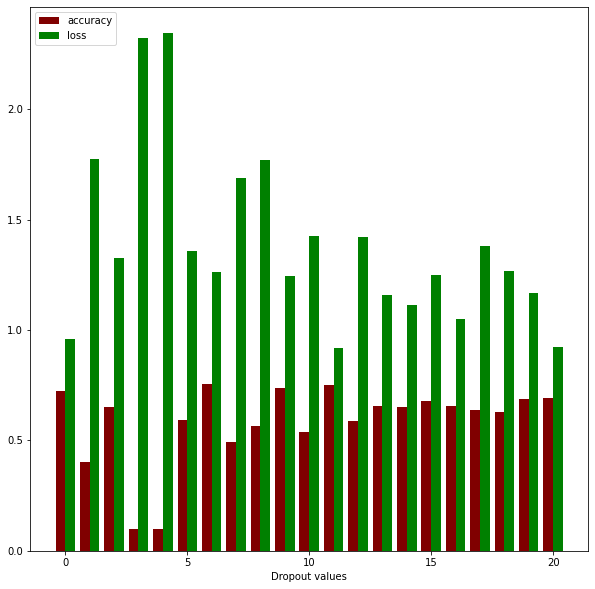

In [164]:
x = range(0, len(all_activations))
y_a = list(bar_activations_accu.values())
y_l = list(bar_activations_loss.values())

fig = plt.figure(figsize = (10, 10))

X_axis = np.arange(len(x))

plt.bar(X_axis - 0.2, y_a, color ='maroon', width = 0.4, label="accuracy")
plt.bar(X_axis + 0.2, y_l, color ='green', width = 0.4, label="loss")
plt.xlabel("Dropout values")
plt.legend(loc="upper left")

plt.show()

We spotted three candidates for the optimal accuracy / loss value. Let's see them.

In [165]:
print(all_activations[0], accu_loss_activations[0])
print(all_activations[11], accu_loss_activations[11])
print(all_activations[20], accu_loss_activations[20])

('sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid') [0.9598416090011597, 0.7214285731315613]
('sigmoid', 'tanh', 'tanh', 'tanh', 'relu') [0.9184916019439697, 0.75]
('relu', 'relu', 'relu', 'relu', 'relu') [0.923980176448822, 0.6928571462631226]


In [166]:
best_activation = all_activations[11]

Ok, the best combination seems to be the middle one. It achieved 75% accuracy nad 0.91 loss for the training set.

#### Fin

Here is our last compilation of the model, with all of the tweaks applied - let's see how it outperforms the first one!

In [208]:
new_categories, limit = get_n_categories(15)
X, y = create_dataset(PATH, new_categories, limit = limit)
X = substracting_dataset(X)
X_train, y_train, X_test, y_test, X_val, y_val = distribute_train_test_val(X, y)
y_train, y_test, y_val  = pd.get_dummies(y_train), pd.get_dummies(y_test), pd.get_dummies(y_val)
mapping = y_train.columns
y_train, y_test, y_val = np.asarray(y_train), np.asarray(y_test), np.asarray(y_val)

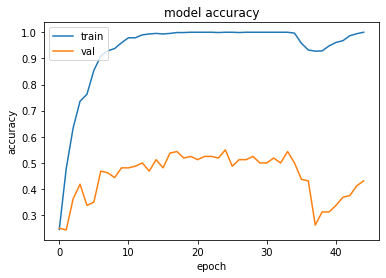

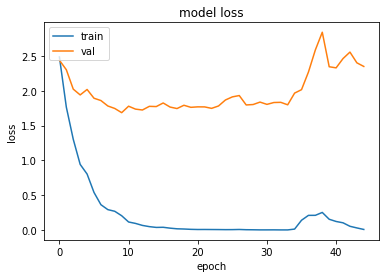

6/6 [==============================] - 0s 5ms/step


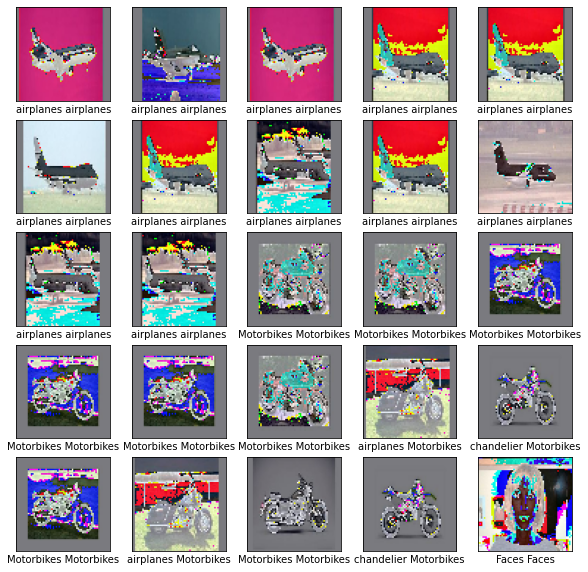

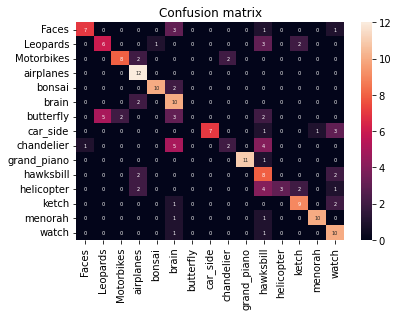

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
model = create_model(15, normalize_flag = False, dropout = best_dropout, activations = best_activation)
history = model.fit(X_train, y_train, 
                    batch_size=32,
                    epochs=250,
                    steps_per_epoch=X_train.shape[0]//32,
                    validation_data=(X_val, y_val),
                    validation_steps=X_val.shape[0]//32,
                    verbose = 0,
                    callbacks=[
                        EarlyStopping(
                            monitor="val_accuracy",
                            patience=20,
                            restore_best_weights=True,
                            verbose=0
                        )
                    ])
cr = plot_all(history, model, X_test, y_test, mapping)

In [214]:
print(cr)

              precision    recall  f1-score   support

       Faces       0.88      0.58      0.70        12
    Leopards       0.55      0.50      0.52        12
  Motorbikes       0.80      0.67      0.73        12
   airplanes       0.60      1.00      0.75        12
      bonsai       0.91      0.83      0.87        12
       brain       0.38      0.83      0.53        12
   butterfly       0.00      0.00      0.00        12
    car_side       1.00      0.58      0.74        12
  chandelier       0.50      0.17      0.25        12
 grand_piano       1.00      0.92      0.96        12
   hawksbill       0.31      0.67      0.42        12
  helicopter       1.00      0.25      0.40        12
       ketch       0.69      0.75      0.72        12
     menorah       0.91      0.83      0.87        12
       watch       0.53      0.83      0.65        12

    accuracy                           0.63       180
   macro avg       0.67      0.63      0.61       180
weighted avg       0.67   

This is our final result- it's still not perfect, but we think that the overfitting problem has been solved in the best way possible. The loss for this model is much lower than the previous ones, even though the accuracy is mediocre - the dataset split is random still which makes the results appear differently. That's why we loaded our previous best model to compare.

In [211]:
model_json = load_model('/content/model3.json', '/content/weights3.h5')
model_json.compile(optimizer='adam', 
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
test_loss = model_json.evaluate(X_test, y_test)
test_loss

6/6 [==============================] - 0s 5ms/step - loss: 383.2134 - accuracy: 0.0944


[383.21337890625, 0.09444444626569748]

The models are sadly not comparable, mostly because the first one was trained on a standardized, not substracted data.

# **Thank you for reading!**

In [215]:
!pip freeze > requirements.txt

In [ ]:
!jupyter nbconvert --to html /content/DL_2_148260_148253.ipynb